#  Project 1:   2021  (Adaline, Back Propagation and Transfer Learning) 
## Part C+D
## Author : Daniel Berkovich
## ID: 313352825
### Made with Jupyter notebook

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Fitting the training data 

In [ ]:
class Adaline(object):

    def __init__(self, n_iterations=100, random_state=1, learning_rate=0.01):
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.coef_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        for _ in range(self.n_iterations):
            activation_function_output = self.activation_function(self.net_input(X))
            errors = y - activation_function_output
            self.coef_[1:] = self.coef_[1:] + self.learning_rate * X.T.dot(errors)
            self.coef_[0] = self.coef_[0] + self.learning_rate * errors.sum()


    def net_input(self, X):
        weighted_sum = np.dot(X, self.coef_[1:]) + self.coef_[0]
        return weighted_sum

    def activation_function(self, X):
        return X


    def predict(self, X):
        return np.where(self.activation_function(self.net_input(X)) >= 0.0, 1, 0)
  

    def score(self, X, y):
        misclassified_data_count = 0
        for xi, target in zip(X, y):
            output = self.predict(xi)
            if (target != output):
                misclassified_data_count += 1
        total_data_count = len(X)
        self.score_ = (total_data_count - misclassified_data_count) / total_data_count
        return self.score_

# Implemting the algorithem 

## Creating a network for our train & test model

## We made the following methods :

###  Loading a data with CSV file
### Split the data in to K folds -cross valdiation 
### Impelmenting  Backpropagation agorithm with Stochastic Gradient Descent
### Fixing the weights of the train, and adusting the data




In [2]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import numpy as np
import matplotlib.pyplot as plt


def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset



def convert_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup



def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats



def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row) - 1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])



def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split



def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0



def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        print('Actual:', len(actual))
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    print("Train: ", train_set)
    prediction_plot(test_set, predicted)
    X = [item[:2] for item in train_set]
    y = [item[2] for item in train_set]
    X = np.array(X)
    y = np.array(y)
    adaline = Adaline(n_iterations=10)
    adaline.fit(X, y)
    print(adaline.score(X, y))
    return scores


def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights) - 1):
        activation += weights[i] * inputs[i]
    return activation


def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))



def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs



def reverse_transfer(output):
    return output * (1.0 - output)



def algo_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network) - 1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * reverse_transfer(neuron['output'])



def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']



def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            algo_error(network, expected)
            update_weights(network, row, l_rate)





# Initialize the network and make perdection :

Data:  [[0.26, -0.33, False], [0.17, 0.51, False], [0.89, -0.34, False], [0.6, -0.98, False], [-0.11, 0.01, False], [-0.47, -0.19, False], [0.41, -0.79, False], [-0.84, 0.06, False], [0.83, 0.44, False], [-0.21, 0.75, False], [-0.22, 0.84, False], [-0.07, -0.94, False], [1.0, -0.95, False], [0.71, 0.18, False], [-0.8, 0.86, False], [0.3, 0.99, False], [-0.51, 0.94, False], [0.82, 0.77, True], [0.27, 0.7, False], [0.67, -0.34, False], [0.84, 0.44, False], [-0.28, 0.66, False], [-0.31, -0.38, False], [-0.73, 0.73, False], [0.29, 0.71, False], [0.66, -0.23, False], [-0.55, -0.06, False], [-0.79, -0.91, False], [0.4, 0.72, False], [-0.86, 0.95, False], [0.13, 0.57, False], [0.81, -0.56, False], [0.67, -0.37, False], [0.4, -0.99, False], [-0.96, -0.92, False], [-0.33, -0.61, False], [-0.16, -0.04, False], [0.19, -0.72, False], [0.13, 0.02, False], [-0.42, -0.09, False], [-0.42, -0.77, False], [-0.79, 0.94, False], [-0.72, 0.78, False], [-0.93, -0.19, False], [-0.71, -0.23, False], [-0.85, -

Actual: 200
Actual: 200
Actual: 200
Actual: 200
Actual: 200
Train:  [[0.37, 0.445, 0], [0.7849999999999999, 0.85, 1], [0.365, 0.065, 0], [0.53, 0.415, 0], [0.21999999999999997, 0.7949999999999999, 0], [0.72, 0.7849999999999999, 0], [0.09999999999999998, 0.05499999999999999, 0], [0.645, 0.76, 0], [0.28, 0.655, 0], [0.08500000000000002, 0.545, 0], [0.42, 0.87, 0], [0.044999999999999984, 0.05499999999999999, 0], [0.99, 0.75, 0], [0.455, 0.24, 0], [0.6799999999999999, 0.9550000000000001, 0], [0.9099999999999999, 0.755, 1], [0.815, 0.655, 0], [0.29000000000000004, 0.97, 0], [0.07, 0.975, 0], [0.08000000000000002, 0.53, 0], [0.52, 0.5, 0], [0.455, 0.845, 0], [0.06, 0.12, 0], [0.8400000000000001, 0.020000000000000018, 0], [0.07500000000000001, 0.09000000000000002, 0], [0.815, 0.24, 0], [0.9450000000000001, 0.32999999999999996, 0], [0.495, 0.07, 0], [0.89, 0.76, 1], [0.47, 0.505, 0], [0.745, 0.995, 0], [0.45, 0.9450000000000001, 0], [0.875, 0.655, 0], [0.98, 0.235, 0], [0.455, 0.42, 0], [0.265

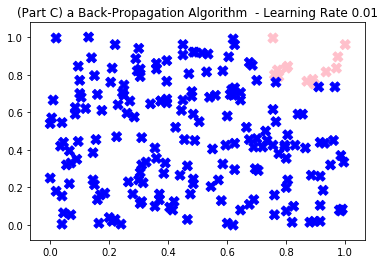

NameError: name 'Adaline' is not defined

In [3]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hLayer = [{'weights': [random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hLayer)
    output_layer = [{'weights': [random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network



def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))


def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return (predictions)


def get_data(size, low, high):
    data = []
    for i in range(size):
        x1 = np.random.randint(low, high + 1) / high
        x2 = np.random.randint(low, high + 1) / high
        y = (x1 > 0.5) & (x2 > 0.5)
        # y = (2 * y - 1)
        data.append([x1, x2, y])
    print('Data: ', data)
    return data


def prediction_plot(data, predictions, layer=0, neuron=0):
    data = np.array(data)
    a1 = np.array(predictions)
    a2 = np.array(predictions)
    a1[a1 == 1] = 100
    a2[a2 == 0] = 100
    a2[a2 == 1] = 0

    print("type(data):", type(data))
    plt.scatter(data[:, 0], data[:, 1], s=a1, marker='X', c='Pink')
    plt.scatter(data[:, 0], data[:, 1], s=a2, marker='X', c='Blue')
    plt.title('(Part C) a Back-Propagation Algorithm  - Learning Rate 0.01')
    plt.show()


if __name__ == '__main__':
    seed(1)
    dataset = get_data(size=1000, low=-100, high=100)
    convert_int(dataset, len(dataset[0]) - 1)
    minmax = dataset_minmax(dataset)
    normalize_dataset(dataset, minmax)
    n_folds = 5
    l_rate = 0.3
    n_epoch = 500
    n_hidden = 5
    scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
    print('Scores: %s' % scores)
    print('Mean Accuracy:' % (sum(scores) / float(len(scores))))

# Part D :
### After we used the trained neurons from the next to the last level of part C (as input) and the Adaline for the output.
### The Adaline can be so accurate for it's adaptive linear neuron that making the network connected with a single linear unit, and it's gives use accurate predicted results as much as possible.


# Summary :

### In the Back-Prop algorithm , we can see that our model is better than a simple one("silly" model) that can always predict the more common result, which is false.

### I realy enjoyed learning about new ways of creating a neural network, using the Adeline and the Back-Prop algorithmes , although it was quite challenging to create the data and it was difficult to figure out how to implement each algorithm.
